In [18]:
import numpy as np
import matplotlib.pyplot as plt

# get data
non_seizure = np.genfromtxt("data/TESTNon.txt", delimiter=" ").astype(np.float32)
pre_seizure = np.genfromtxt("data/TESTPre.txt", delimiter=" ").astype(np.float32)
seizure = np.genfromtxt("data/TESTSeiz.txt", delimiter=" ").astype(np.float32)

In [30]:
non_seizure.shape

(12, 76800)

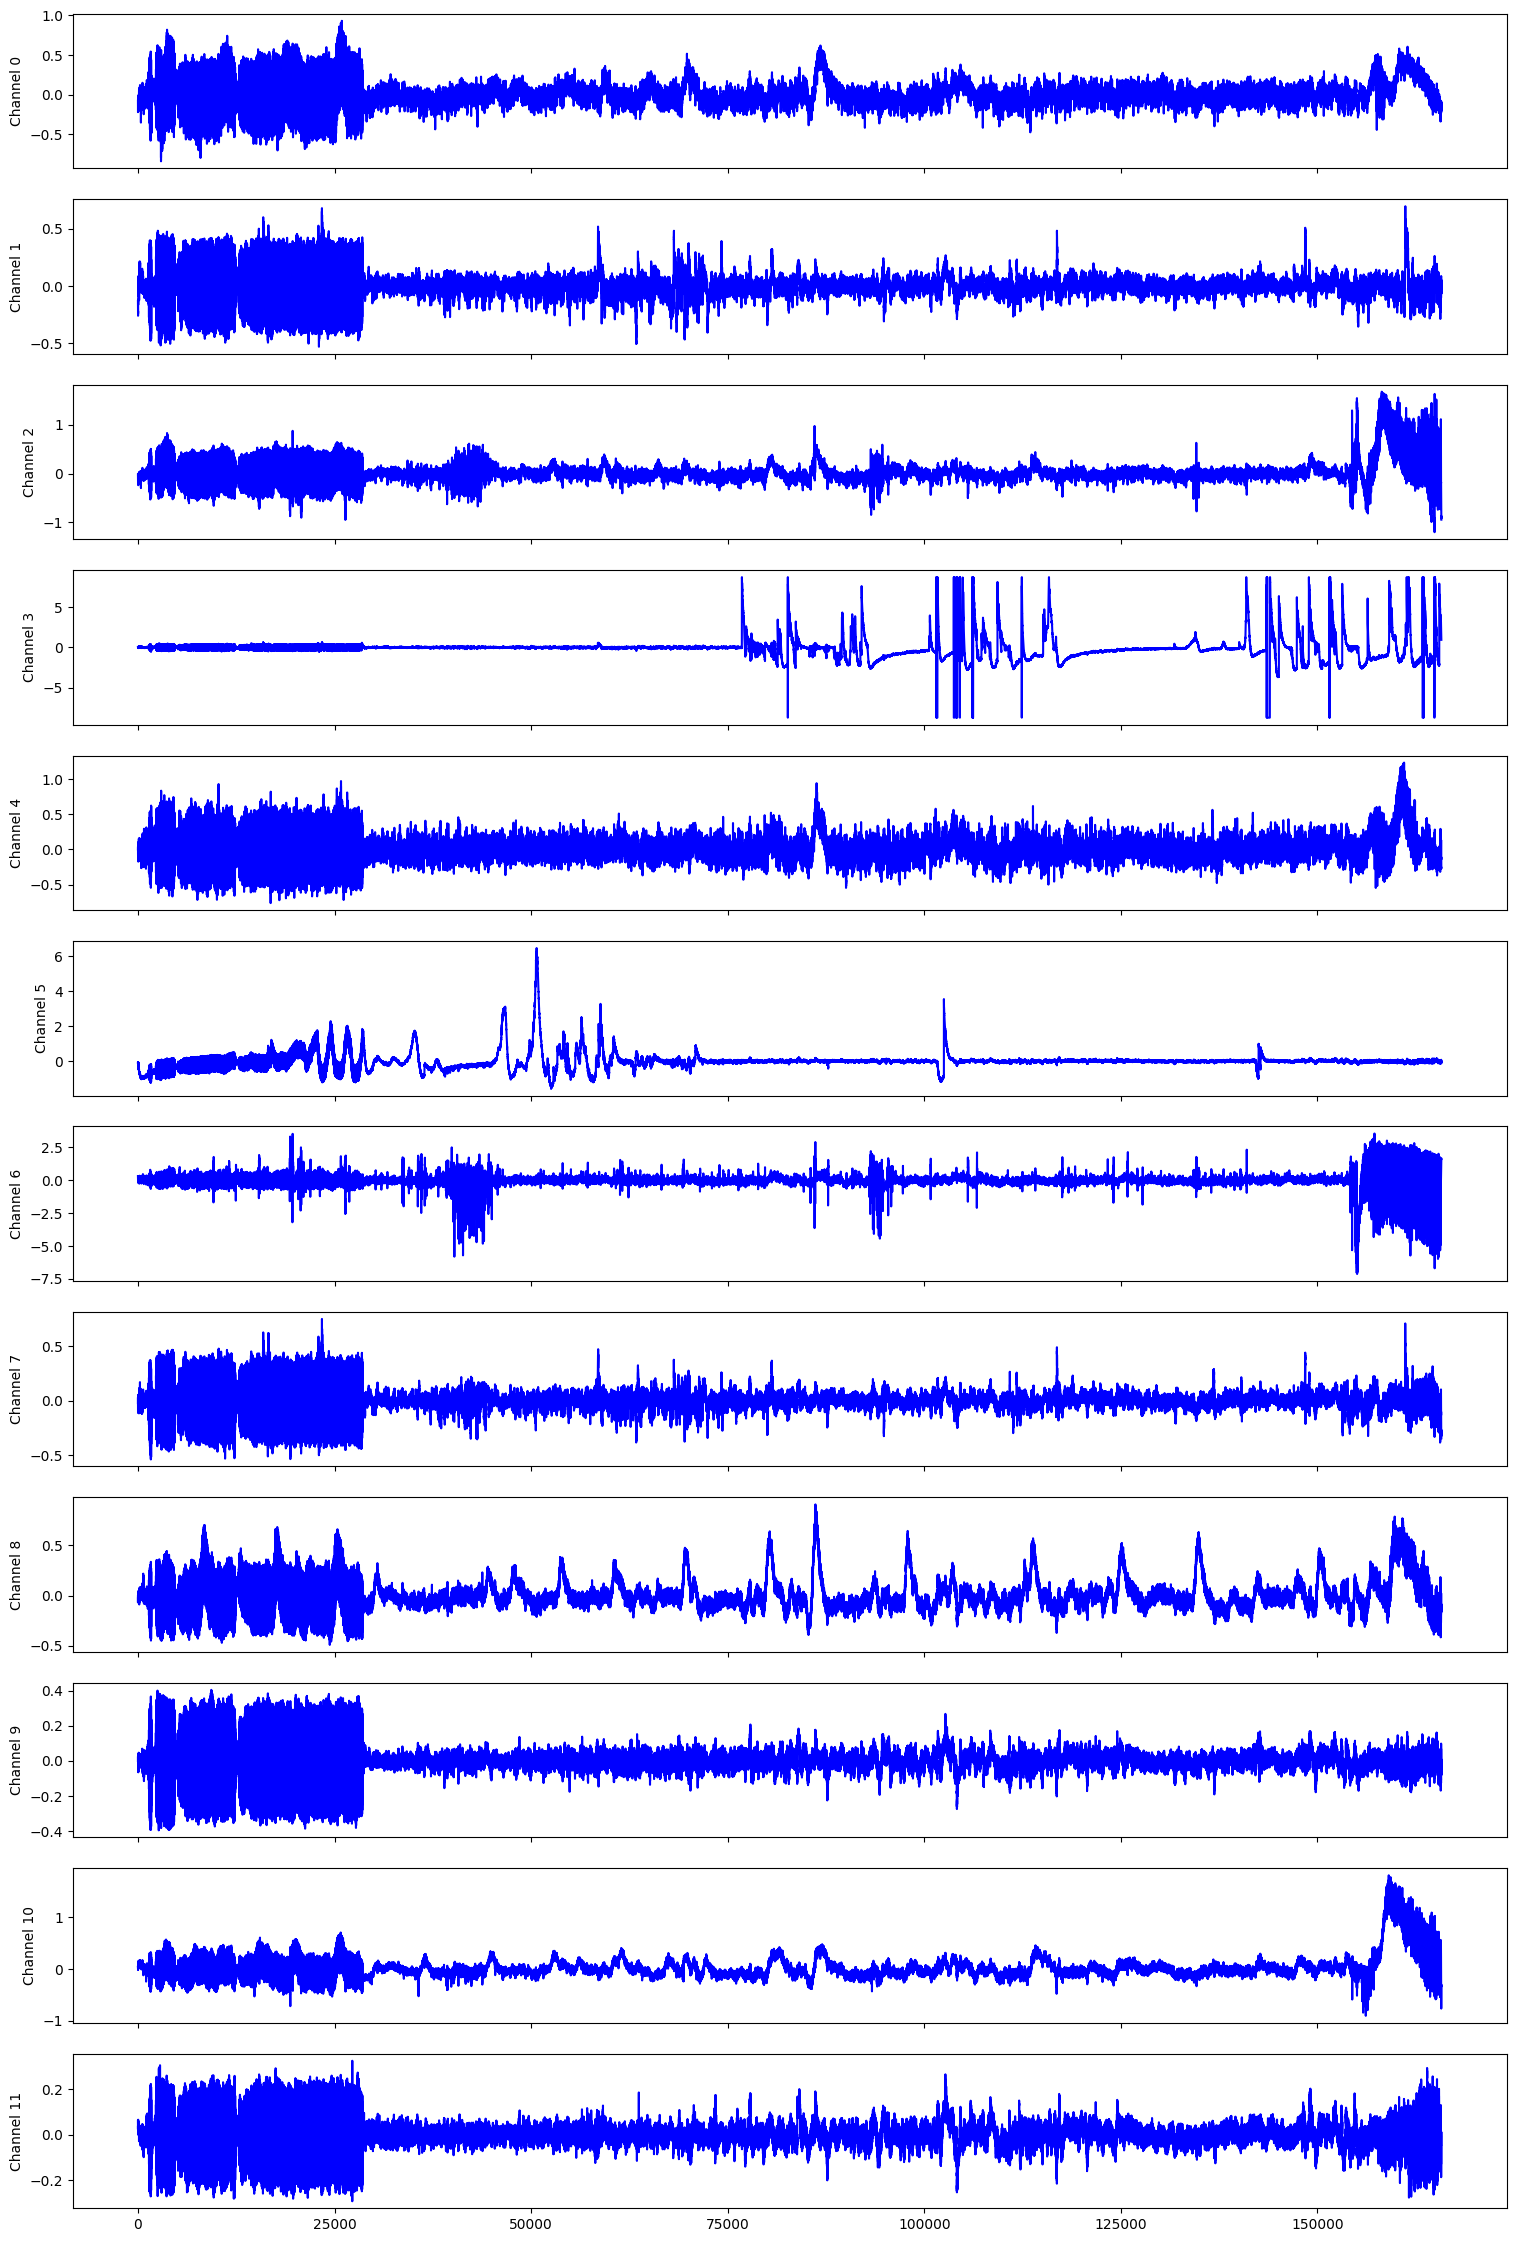

In [24]:
eeg_data = np.concatenate((non_seizure, pre_seizure, seizure), axis=1)

# visualize for good measure
time = [i for i in range(eeg_data.shape[1])]

fig, axs = plt.subplots(12, 1, sharex=True)
fig.set_size_inches(18.5, 28.5)

for c in range(12):
    axs[c].plot(time, eeg_data[c], 'b')
    axs[c].set_ylabel(f"Channel {c}")

## State 1

Detected at `t=87424`.

In [25]:
from importlib import reload
import CPD.warm

reload(CPD.warm)

<module 'CPD.warm' from 'c:\\Users\\saidmf\\Desktop\\Projects\\eeg-regime-change\\CPD\\warm.py'>

In [27]:
# put arrays in dictionary for labels
channels = {}
for i in range(12):
    channels[f"channel_{i}"] = eeg_data[i]

In [28]:
# warm up for 20 seconds and determine best lags
# (runs in 5 mins)
arpwarm = CPD.warm.ARPWarm(channels, n0=20, chunks=6)
arpwarm.warmup()

['channel_0', 'channel_1']
['channel_2', 'channel_3']
['channel_4', 'channel_5']
['channel_6', 'channel_7']
['channel_8', 'channel_9']
['channel_10', 'channel_11']


In [8]:
import CPD.benchmark
reload(CPD.benchmark)

<module 'CPD.benchmark' from 'c:\\Users\\saidmf\\Desktop\\Projects\\eeg-regime-change\\CPD\\benchmark.py'>

In [31]:
cpd = CPD.benchmark.Online(arpwarm, k=5, M=4)

In [32]:
change_point, forecasts = cpd.run()

cpt = max(change_point.values())

print(f"change point detected at t={cpt}")

STEP 20
STEP 21
STEP 22
channel_5 rejection incremented 1
STEP 23
channel_5 rejection incremented 2
STEP 24
channel_5 rejection incremented 3
STEP 25
channel_5 rejection incremented 4
channel_2 rejection incremented 1
STEP 26
channel_10 rejection incremented 1
channel_5 rejection incremented 5
channel_2 rejection incremented 2
STEP 27
channel_10 rejection incremented 2
channel_5 rejection incremented 6
channel_2 rejection incremented 3
STEP 28
channel_10 rejection incremented 3
channel_5 rejection incremented 7
channel_0 rejection incremented 1
channel_2 rejection incremented 4
STEP 29
channel_0 rejection incremented 2
channel_10 rejection incremented 4
channel_5 rejection incremented 8
channel_2 rejection incremented 5
STEP 30
channel_10 rejection incremented 5
channel_5 rejection incremented 9
channel_0 resetting rejection
channel_2 resetting rejection
STEP 31
channel_0 rejection incremented 1
channel_10 rejection incremented 6
channel_5 rejection incremented 10
channel_2 rejection i

In [33]:
change_point

{'channel_5': 4096,
 'channel_10': 29696,
 'channel_3': 78080,
 'channel_2': 87040,
 'channel_0': 87424}

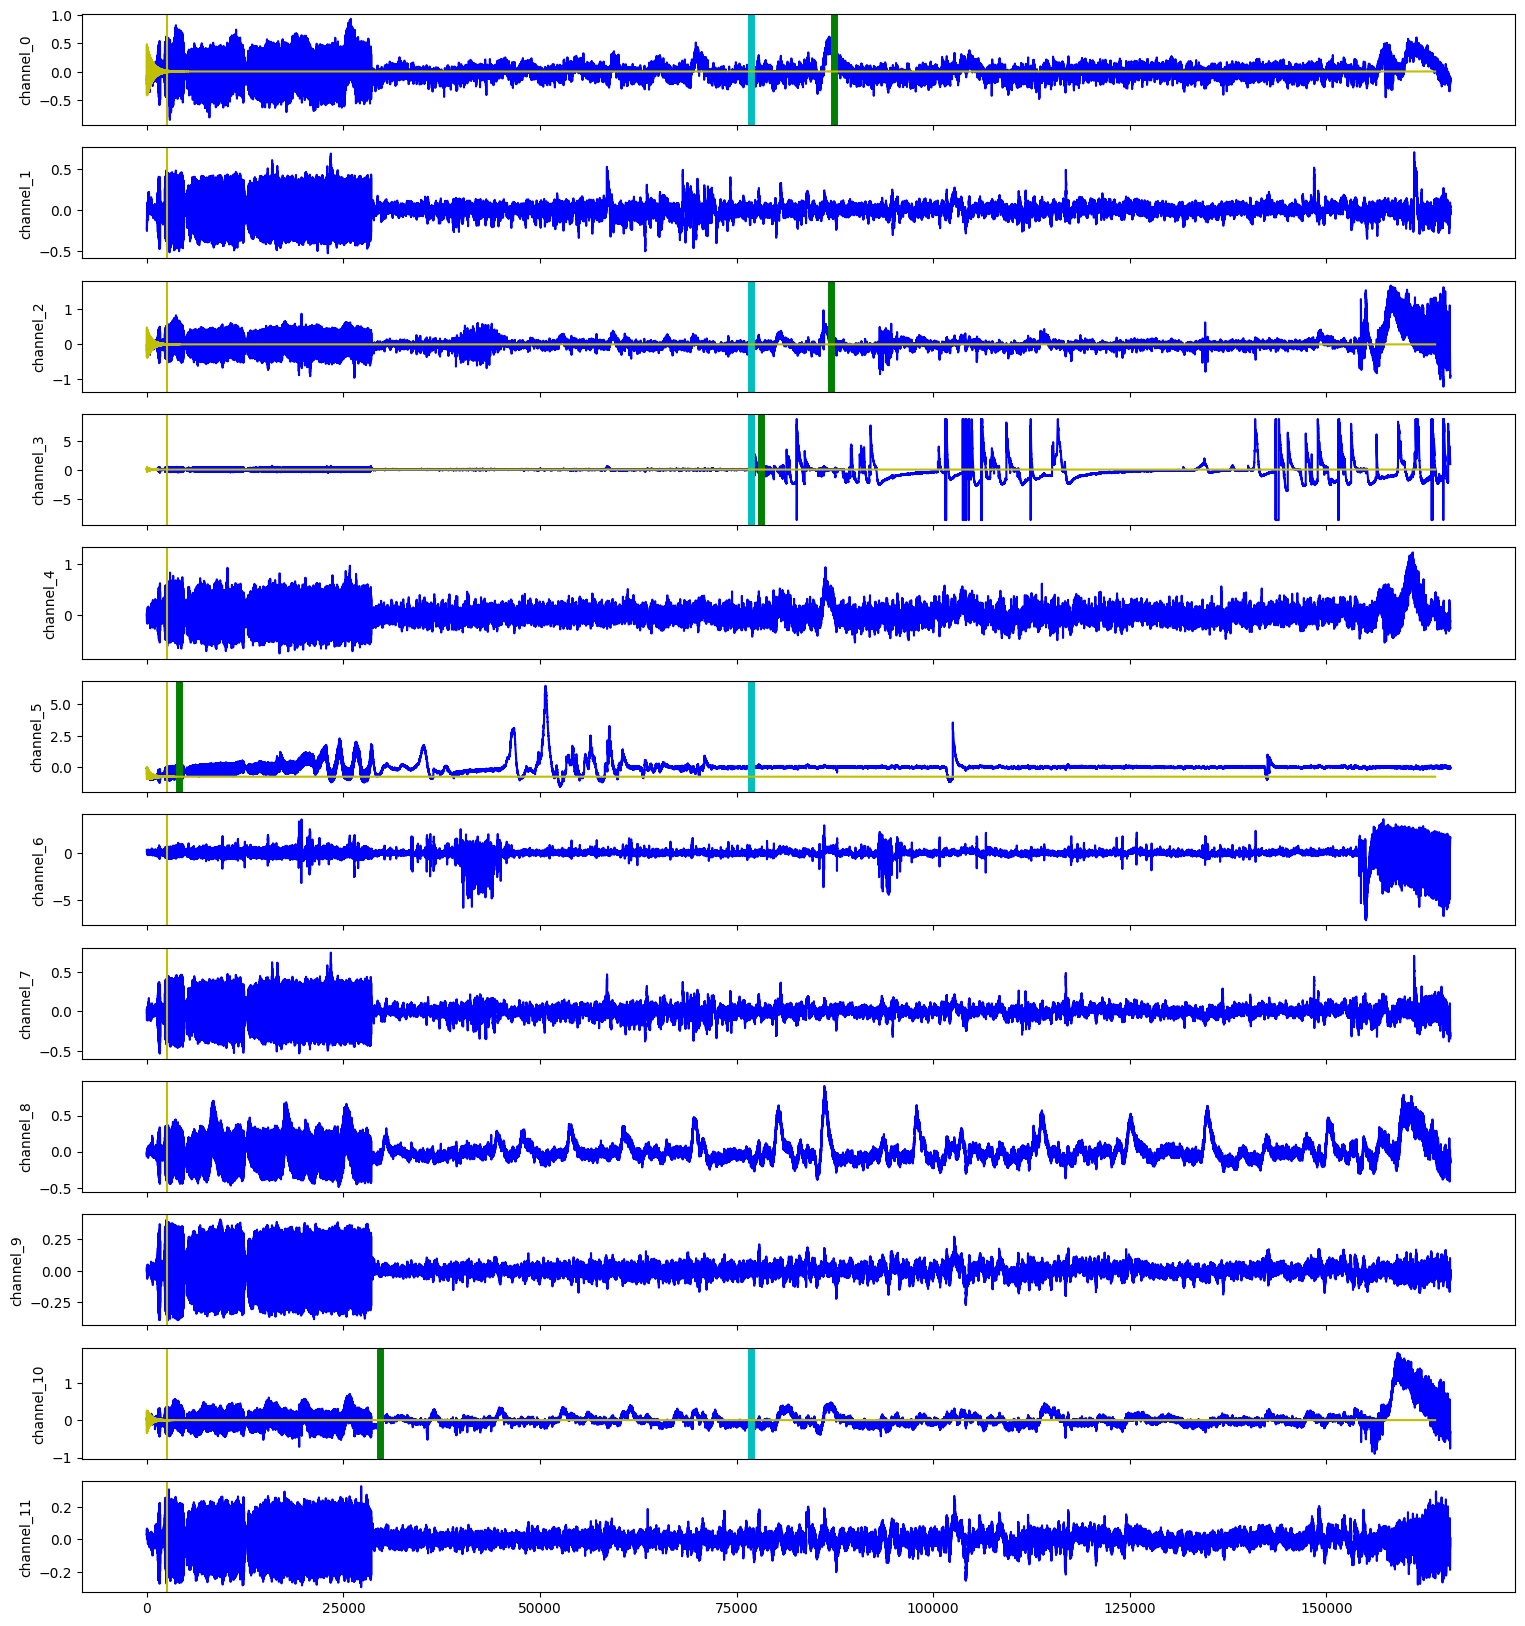

In [34]:
time = [i for i in range(eeg_data.shape[1])]

warmup = 20 * 128
actual_change = 76800

fig, axs = plt.subplots(eeg_data.shape[0], 1, sharex=True)
fig.set_size_inches(18.5, 20.5)

for c in range(eeg_data.shape[0]):
    chan = f"channel_{c}"
    axs[c].plot(time, channels[chan], 'b')
    
    axs[c].axvline(x=warmup, c='y')
    if chan in change_point:
        cpt = change_point[chan]
        axs[c].axvline(x=cpt, c='g', linewidth=5)
        axs[c].axvline(x=actual_change, c='c', linewidth=5)
        fore_time = [i for i in range(len(forecasts[chan]))]
        axs[c].plot(fore_time, forecasts[chan], 'y')
    axs[c].set_ylabel(chan)

## State 2

Detected at `t=23168`

In [38]:
# get data past detected change-point `t=28928`

post_channels = {}
for i in range(len(eeg_data)):
    post_channels[f"channel_{i}"] = eeg_data[i][cpt:]

In [39]:
post_channels["channel_0"].shape

(136064,)

In [40]:
# warm up for 20 seconds and determine best lags
# (warms up in ~7 mins)

arpwarm2 = CPD.warm.ARPWarm(post_channels, n0=20, chunks=6)
arpwarm2.warmup()

['channel_0', 'channel_1']
['channel_2', 'channel_3']
['channel_4', 'channel_5']
['channel_6', 'channel_7']
['channel_8', 'channel_9']
['channel_10', 'channel_11']


In [41]:
cpd2 = CPD.benchmark.Online(arpwarm2, k=5, M=4)

In [42]:
change_points2, forecasts2 = cpd2.run()

cpt2 = max(change_points2.values())

print(f"change point detected at t={cpt2}")

STEP 20
STEP 21
channel_5 rejection incremented 1
STEP 22
channel_5 rejection incremented 2
STEP 23
channel_5 rejection incremented 3
STEP 24
channel_8 rejection incremented 1
channel_5 rejection incremented 4
STEP 25
channel_8 rejection incremented 2
channel_5 resetting rejection
channel_7 rejection incremented 1
STEP 26
channel_8 rejection incremented 3
channel_7 resetting rejection
STEP 27
channel_8 rejection incremented 4
channel_5 rejection incremented 1
STEP 28
channel_8 rejection incremented 5
channel_8 detected change point! Halting.
channel_5 rejection incremented 2
channel_0 rejection incremented 1
STEP 29
channel_0 resetting rejection
channel_5 rejection incremented 3
STEP 30
channel_5 rejection incremented 4
STEP 31
channel_5 rejection incremented 5
channel_5 detected change point! Halting.
STEP 32
STEP 33
channel_10 rejection incremented 1
STEP 34
channel_10 resetting rejection
STEP 35
channel_10 rejection incremented 1
STEP 36
channel_10 rejection incremented 2
STEP 37
ch

76800


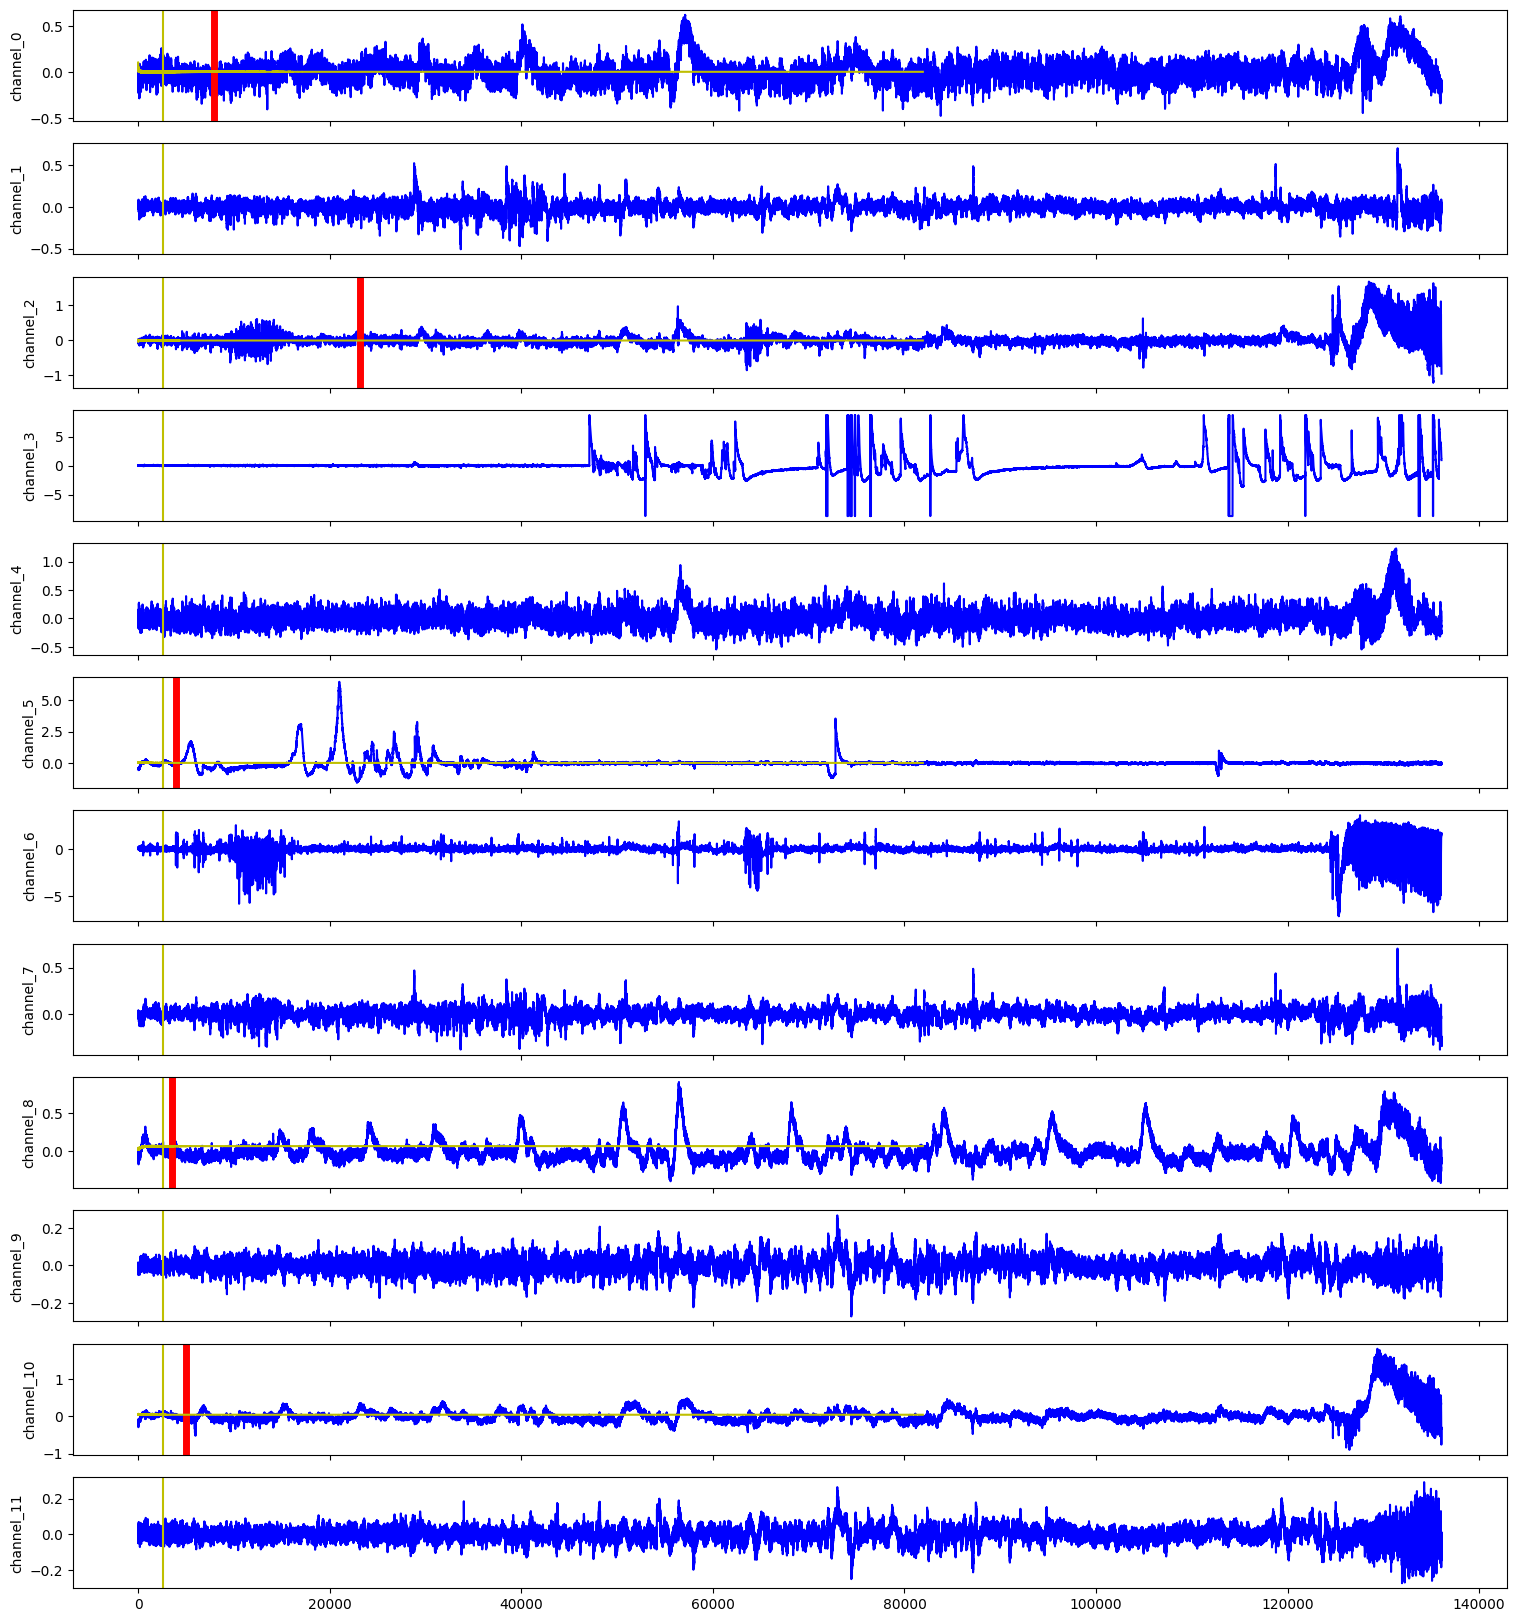

In [44]:
warmup = 20 * 128
# actual_change = 50000 - (cpt - 28000)

time = [i for i in range(post_channels["channel_0"].shape[0])]

fig, axs = plt.subplots(len(post_channels), 1, sharex=True)
fig.set_size_inches(18.5, 20.5)

for c in range(eeg_data.shape[0]):
    chan = f"channel_{c}"
    axs[c].plot(time, post_channels[chan], 'b')

    axs[c].axvline(x=warmup, c='y')

    if chan in change_points2:
        next_cpt = change_points2[chan]
        axs[c].axvline(x=next_cpt, c='r', linewidth=5)
        # axs[c].axvline(x=actual_change, c='m', linewidth=5)
        fore_time = [i for i in range(len(forecasts2[chan][:time[-1]]))]
        axs[c].plot(fore_time, forecasts2[chan][:time[-1]], 'y')

    axs[c].set_ylabel(chan)

print(actual_change)